In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_arc(ax, center, radius, start_point, end_point, resolution=50, **kwargs):
    """
    Plot an arc based on a circle's center, radius, and start/end points.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    center : tuple or array
        (x, y) coordinates of the circle center.
    radius : float
        Radius of the circle.
    start_point : tuple or array
        (x, y) coordinates of the starting point of the arc.
    end_point : tuple or array
        (x, y) coordinates of the ending point of the arc.
    resolution : int, optional
        Number of points to use for the arc (default: 50).
    **kwargs : dict
        Additional keyword arguments to pass to plt.plot().
    
    Returns:
    --------
    line : matplotlib.lines.Line2D
        The plotted line.
    """
    # Calculate angles from the start and end points
    start_dx = start_point[0] - center[0]
    start_dy = start_point[1] - center[1]
    end_dx = end_point[0] - center[0]
    end_dy = end_point[1] - center[1]
    
    start_angle = math.atan2(start_dy, start_dx)
    end_angle = math.atan2(end_dy, end_dx)
    
    # Verify points are on the circle (approximately)
    start_dist = math.sqrt(start_dx**2 + start_dy**2)
    end_dist = math.sqrt(end_dx**2 + end_dy**2)
    
    if abs(start_dist - radius) > 1e-10 or abs(end_dist - radius) > 1e-10:
        raise ValueError(f"Points must be on the circle. Start dist: {start_dist}, End dist: {end_dist}, Radius: {radius}")
    
    # Determine the correct arc direction
    # We need to decide whether to go clockwise or counterclockwise from start to end
    # This is a bit tricky as we need to consider the shorter arc by default
    
    # Calculate the angle difference, ensuring it's between -π and π
    angle_diff = end_angle - start_angle
    if angle_diff > math.pi:
        angle_diff -= 2 * math.pi
    elif angle_diff < -math.pi:
        angle_diff += 2 * math.pi
    
    # Generate the arc based on angle difference direction
    if angle_diff >= 0:
        # Counterclockwise arc
        theta = np.linspace(start_angle, start_angle + angle_diff, resolution)
    else:
        # Clockwise arc
        theta = np.linspace(start_angle, start_angle + angle_diff, resolution)
    
    # Calculate points on the arc
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    
    # Plot the arc
    line, = ax.plot(x, y, **kwargs)
    
    return line

def compute_intersection_arc_poly(arc_circ_center, arc_source, polygon_points):
    intersections = []
    rad = np.linalg.norm(arc_circ_center-arc_source)
    for i in range(len(polygon_points)-1):
        seg = [polygon_points[i], polygon_points[i+1]]
        d1 = np.linalg.norm(arc_circ_center- seg[0])
        d2 = np.linalg.norm(arc_circ_center- seg[1])
        if d1<rad and d2<rad:
            intersections.append(None)
            continue
        if d1>rad and d2>rad:
            intersections.append(None)
            continue

        #there exists an intersection
        p1 = seg[0]-arc_circ_center
        p2 = seg[1]-arc_circ_center
        A = np.linalg.norm(p1)**2+np.linalg.norm(p2)**2 - 2* np.dot(p1,p2)
        B = 2*(-np.linalg.norm(p2)**2 + np.dot(p1,p2))
        C = -rad**2+ np.linalg.norm(p2)**2

        disc = np.sqrt(B**2-4*A*C)
        sol1 = (-B + disc)/(2*A)
        sol2 = (-B - disc)/(2*A)
        if sol1<=1 and sol1 >=0:
            assert sol2>1 or sol2 <0
            sol = sol1
        else:
            assert sol2<=1 and sol2 >=0
            sol = sol2

        intersections.append(p1*sol + p2*(1-sol))
    return intersections

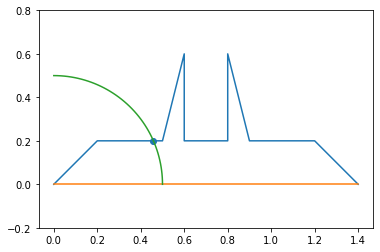

In [2]:
fig, ax = plt.subplots()
def plot_adornment_poly(ax, points):
    ax.plot(points[:,0], points[:,1])
    ax.plot([points[0,0], points[-1,0]], [points[0,1], points[-1,1]])
    ax.axis('equal')
points = np.array([
    [0, 0],
    [0.2, 0.2],
    [0.5, 0.2],
    [0.6, 0.6],
    [0.6, 0.2],
    [0.8, 0.2],
    [0.8, 0.6],
    [0.9, 0.2],
    [1.2, 0.2],
    [1.4,0]
])

plot_adornment_poly(ax, points)
intersections = compute_intersection_arc_poly(np.array([0,0]), np.array([0,0.5]), points)
ints = np.array([i for i in intersections if i is not None])
plot_arc(ax, [0,0], 0.5, [0.0, 0.5], [0.5,0])
ax.scatter(ints[:,0], ints[:,1])

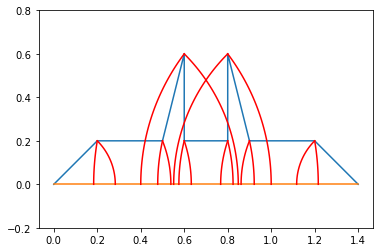

In [3]:
fig, ax = plt.subplots()
plot_adornment_poly(ax, points)

# right lenses
center = np.array([0,0])
for pt in points:
    radius = np.linalg.norm(pt-center)
    bot_int = np.array([radius, 0])
    plot_arc(ax, center, radius, pt, bot_int, color = 'r')

# left lenses
center = np.array([np.max(points[:,0]), 0])

for pt in points:
    radius = np.linalg.norm(pt-center)
    bot_int = np.array([center[0]-radius, 0])
    plot_arc(ax, center, radius, bot_int, pt, color = 'r')

In [4]:
class LineSegment:
    def __init__(self, start, end):
        self.start = start
        self.end = end

class Arc:
    def __init__(self, center, radius, left_boundary_point, right_boundary_point, is_left_arc):
        self.center = center
        self.radius = radius
        self.left_boundary_point = left_boundary_point
        self.right_boundary_point = right_boundary_point
        cords1 = left_boundary_point-self.center
        cords2 = right_boundary_point-self.center
        self.theta_start = np.arctan2(cords1[1], cords1[0])
        self.theta_end = np.arctan2(cords2[1], cords2[0])
        self.range = [np.min([self.theta_start, self.theta_end]), np.max([self.theta_start, self.theta_end])]
        self.is_left_arc = is_left_arc
    
    def angle_containted(self, theta):
        return self.range[0]<= theta and self.range[1]>= theta

In [5]:
def get_intersections_circles(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return (x3, y3, x4, y4)
    
def compute_arc_arc_intersection(arc_1 : Arc, arc_2 : Arc):
    dist = np.linalg.norm(arc_1.center - arc_2.center)
    if dist> arc_1.radius + arc_2.radius:
        return []
    
    #circles intersect 
    ints = get_intersections_circles(arc_1.center[0],
                                     arc_1.center[1],
                                     arc_1.radius,
                                     arc_2.center[0],
                                     arc_2.center[1],
                                     arc_2.radius)
    assert ints is not None
    int1 = np.array([ints[0], ints[1]])
    int2 = np.array([ints[2], ints[3]])
    intersections = []
    #check if the intersections are actually part of the arcs
    #intersection 1
    for intersection in [int1, int2]:
        cords1 = intersection-arc_1.center
        theta_int1 = np.arctan2(cords1[1], cords1[0])
        cords2 = intersection-arc_2.center
        theta_int2 = np.arctan2(cords2[1], cords2[0])

        if arc_1.angle_containted(theta_int1) and arc_2.angle_containted(theta_int2):
            intersections.append(intersection)
    return intersections

def compute_arc_line_segment_intersection(arc, line_segment):
    rad = arc.radius

    d1 = np.linalg.norm(arc.center- line_segment.start)
    d2 = np.linalg.norm(arc.center- line_segment.end)
    if d1<rad and d2<rad:
        return []
    if d1>rad and d2>rad:
        return []

    #there exists an intersection
    p1 = line_segment.start-arc.center
    p2 = line_segment.end-arc.center
    A = np.linalg.norm(p1)**2+np.linalg.norm(p2)**2 - 2* np.dot(p1,p2)
    B = 2*(-np.linalg.norm(p2)**2 + np.dot(p1,p2))
    C = -rad**2+ np.linalg.norm(p2)**2

    disc = np.sqrt(B**2-4*A*C)
    sol1 = (-B + disc)/(2*A)
    sol2 = (-B - disc)/(2*A)
    intersections = []
    if sol1<=1 and sol1>=0:
        intersections.append(p1*sol1 + p2*(1-sol1))
    if sol2<=1 and sol2>=0:
        intersections.append(p1*sol2 + p2*(1-sol2))

    return intersections

In [6]:
from typing import Union

def compute_arc_intersections(arc :Arc, boundary : list[Union[Arc,LineSegment]], tol=1e-6):
    intersections = []
    for element in boundary:
        if isinstance(element, LineSegment):
            element_intersections = compute_arc_line_segment_intersection(arc, element)
        else:
            assert isinstance(element, Arc)
            element_intersections = compute_arc_arc_intersection(arc, element)
        intersections.extend(element_intersections)

    if not len(intersections):
        return None
    if arc.is_left_arc:
        point_to_toss = arc.right_boundary_point
    else:
        point_to_toss = arc.left_boundary_point
    
    #go through ints if find then toss
    intersections = [intersection for intersection in intersections if np.linalg.norm(intersection - point_to_toss) > tol]
    #compute angles of intersections
    angs = [np.arctan2(intersection-arc.center[1], intersection-arc.center[0]) for intersection in intersections]

    if arc.is_left_arc:
        idx = np.argmin(angs)
    else:
        idx = np.argmax(angs)

    return intersections[idx]


In [33]:
def put_arc_in_slender_hull(arc :Arc, i_segment_origin, slender_hull : list[Union[Arc,LineSegment]], tol=1e-6):
    intersections = []
    source_component_inds = []
    for i_element, element in enumerate(slender_hull):
        if isinstance(element, LineSegment):
            element_intersections = compute_arc_line_segment_intersection(arc, element)
        else:
            assert isinstance(element, Arc)
            element_intersections = compute_arc_arc_intersection(arc, element)
        intersections.extend(element_intersections)
        source_component_inds.extend([i_element]*len(element_intersections))

    if not len(intersections):
        return None
    if arc.is_left_arc:
        point_to_toss = arc.right_boundary_point
    else:
        point_to_toss = arc.left_boundary_point
    
    #go through ints if find then toss
    intersections = [intersection for intersection in intersections if np.linalg.norm(intersection - point_to_toss) > tol]
    #compute angles of intersections
    angs = [np.arctan2(intersection-arc.center[1], intersection-arc.center[0]) for intersection in intersections]

    if arc.is_left_arc:
        idx = np.argmin(angs)
    else:
        idx = np.argmax(angs)

    intersection = intersections[idx]
    src_ind = source_component_inds[idx]

    # updated_slender_hull = []
    # for i in range(len(slender_hull)):
    #     if i < src_ind and i < i_segment_origin:
    #         updated_slender_hull.append(slender_hull[i])
    #     elif arc.is_left_arc and i >= src_ind:
    #         assert src_ind <= i_segment_origin
    #         do something
    #     elif (not arc.is_left_arc) and i >= i_segment_origin:
    #         assert i_segment_origin <= src_ind
    #         do something
    #     elif i > src_ind and i > i_segment_origin:
    #         updated_slender_hull.append(slender_hull[i])
    if arc.is_left_arc:
        assert src_ind <= i_segment_origin
        before_arc = slender_hull[:src_ind]
        after_arc = slender_hull[i_segment_origin+1:]
        # trim the intersecting segment
        elem = slender_hull[src_ind]
        if isinstance(slender_hull[src_ind], LineSegment):
            trimmed_element = LineSegment(elem.start, intersection)
        else:
            # we know it's a right arc
            assert not elem.is_left_arc
            trimmed_element = Arc(elem.center, elem.radius, elem.start, intersection, is_left_arc=False)
        updated_slender_hull = before_arc + trimmed_element + after_arc
    else: 
        assert i_segment_origin <= src_ind
        before_arc = slender_hull[:i_segment_origin]
        after_arc = slender_hull[src_ind+1:]
        # trim the intersecting segment
        elem = slender_hull[src_ind]
        if isinstance(slender_hull[src_ind], LineSegment):
            trimmed_element = LineSegment(intersection, elem.end)
        else:
            # we know it's a left arc
            assert elem.is_left_arc
            trimmed_element = Arc(elem.center, elem.radius, intersection, elem.end, is_left_arc=True)
        updated_slender_hull = before_arc + trimmed_element + after_arc
    

    return updated_slender_hull

    # update the component that is intersected with
    # delete elements in between


In [7]:
list_1 = []
list_1.extend([])
print(list_1)

[]


In [21]:
points

array([[0. , 0. ],
       [0.2, 0.2],
       [0.5, 0.2],
       [0.6, 0.6],
       [0.6, 0.2],
       [0.8, 0.2],
       [0.8, 0.6],
       [0.9, 0.2],
       [1.2, 0.2],
       [1.4, 0. ]])

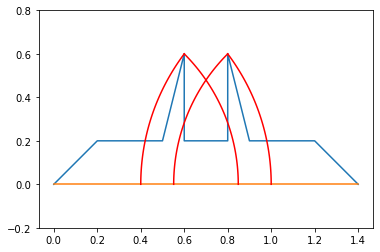

In [ ]:
boundary = []
for i in range(len(points)-1):
    boundary.append(LineSegment(points[i,:], points[i+1,:]))

right_arcs = []
left_arcs = []
# right lenses
right_center = np.array([0,0])
# for pt in points:
#     radius = np.linalg.norm(pt-center)
#     bot_intersection = np.array([radius, 0])
#     right_arcs.append(Arc(center, radius, pt, bot_intersection, False))

# left lenses
left_center = np.array([np.max(points[:,0]), 0])
# for pt in points:
#     radius = np.linalg.norm(pt-center)
#     bot_intersection = np.array([center[0]-radius, 0])
#     left_arcs.append(Arc(center, radius, bot_intersection, pt, True))
fig, ax = plt.subplots()
plot_adornment_poly(ax, points)
arcs = []
slender_hull = boundary
for i_vert, vert in enumerate(points):
    if i_vert > 0 and i_vert < len(points)-1:
        # left arc
        radius = np.linalg.norm(vert-left_center)
        bot_intersection = np.array([center[0]-radius, 0])
        left_arc = Arc(left_center, radius, bot_intersection, vert, True)
        

        # check if arc is under corresponding segment
        segment_delta = vert - points[i_vert-1]
        segment_angle = np.arctan2(segment_delta[1], segment_delta[0])
        arc_delta = vert - left_center
        arc_tangent_angle = np.arctan2(arc_delta[1], arc_delta[0]) - np.pi/2
        # print(f" segment delta {segment_delta}")
        # print(f" segment agnle {segment_angle}")
        # print(f"vert {vert}")
        if arc_tangent_angle < segment_angle:
            plot_arc(ax, left_center, radius, vert, bot_intersection, color = 'r')
            
            # update slender adornment
            i_origin_segment = slender_hull.index(boundary[i_vert-1])
            # TODO not sure how to get the right index of origin segment.  not sure how to loop ver only points that still exist.  perhaps use index list function
            slender_hull = put_arc_in_slender_hull(left_arc, )

        # right arc
        radius = np.linalg.norm(vert-right_center)
        bot_intersection = np.array([radius, 0])
        right_arc = Arc(right_center, radius, vert, bot_intersection, False)

        # check if arc is under corresponding segment
        segment_delta = points[i_vert+1] - vert
        segment_angle = np.arctan2(segment_delta[1], segment_delta[0])
        arc_delta = vert - right_center
        arc_tangent_angle = np.arctan2(arc_delta[1], arc_delta[0]) - np.pi/2

        if arc_tangent_angle > segment_angle:
            # arcs.append(left_arc)
            plot_arc(ax, right_center, radius, vert, bot_intersection, color = 'r')
    

########
# initialize slender adornment as poly CHECK
# for each vert in poly
    # for left and right
        # generate arc CHECK
        # check if arc is under corresponding segment CHECK
        # if not:
            # compute intersections with slender adornment
            # insert it into adornment; chuck everything between closest intersection and vert (source vert to arc)



In [23]:
arc_tangent_angle

-1.4056476493802696

In [19]:
vert

array([1.4, 0. ])

In [18]:
segment_angle

-0.7853981633974484

In [ ]:
# find normals at vertices
# then compare to 'correct' sphere normal

In [ ]:
# for each vert
# calculate the lens
# check the boundary of the lens for intersections with the poly.

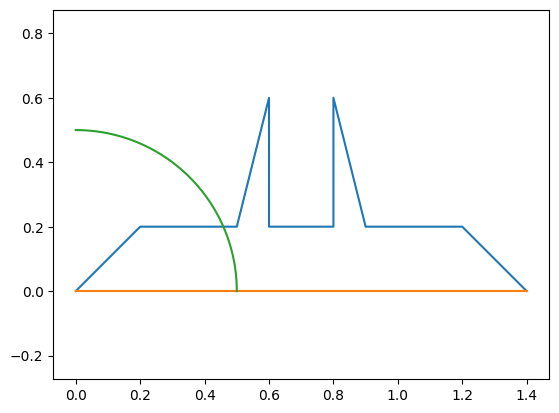

In [3]:
#assume base is 0-1 along x axis
def plot_adornment_poly(ax, points):
    ax.plot(points[:,0], points[:,1])
    ax.plot([points[0,0], points[-1,0]], [points[0,1], points[-1,1]])
    ax.axis('equal')

fig, ax = plt.subplots()

points = np.array([
    [0, 0],
    [0.2, 0.2],
    [0.5, 0.2],
    [0.6, 0.6],
    [0.6, 0.2],
    [0.8, 0.2],
    [0.8, 0.6],
    [0.9, 0.2],
    [1.2, 0.2],
    [1.4,0]
])

plot_adornment_poly(ax, points)
plot_arc(ax, [0,0], 0.5, [0.0, 0.5], [0.5,0])

SyntaxError: unterminated string literal (detected at line 163) (201026837.py, line 163)

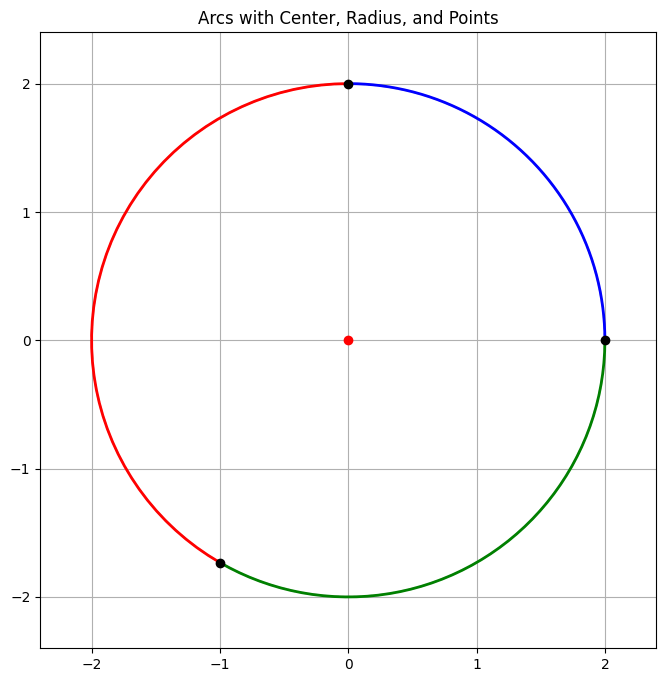

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_arc(ax, center, radius, start_point, end_point, resolution=50, **kwargs):
    """
    Plot an arc based on a circle's center, radius, and start/end points.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    center : tuple or array
        (x, y) coordinates of the circle center.
    radius : float
        Radius of the circle.
    start_point : tuple or array
        (x, y) coordinates of the starting point of the arc.
    end_point : tuple or array
        (x, y) coordinates of the ending point of the arc.
    resolution : int, optional
        Number of points to use for the arc (default: 50).
    **kwargs : dict
        Additional keyword arguments to pass to plt.plot().
    
    Returns:
    --------
    line : matplotlib.lines.Line2D
        The plotted line.
    """
    # Calculate angles from the start and end points
    start_dx = start_point[0] - center[0]
    start_dy = start_point[1] - center[1]
    end_dx = end_point[0] - center[0]
    end_dy = end_point[1] - center[1]
    
    start_angle = math.atan2(start_dy, start_dx)
    end_angle = math.atan2(end_dy, end_dx)
    
    # Verify points are on the circle (approximately)
    start_dist = math.sqrt(start_dx**2 + start_dy**2)
    end_dist = math.sqrt(end_dx**2 + end_dy**2)
    
    if abs(start_dist - radius) > 1e-10 or abs(end_dist - radius) > 1e-10:
        raise ValueError(f"Points must be on the circle. Start dist: {start_dist}, End dist: {end_dist}, Radius: {radius}")
    
    # Determine the correct arc direction
    # We need to decide whether to go clockwise or counterclockwise from start to end
    # This is a bit tricky as we need to consider the shorter arc by default
    
    # Calculate the angle difference, ensuring it's between -π and π
    angle_diff = end_angle - start_angle
    if angle_diff > math.pi:
        angle_diff -= 2 * math.pi
    elif angle_diff < -math.pi:
        angle_diff += 2 * math.pi
    
    # Generate the arc based on angle difference direction
    if angle_diff >= 0:
        # Counterclockwise arc
        theta = np.linspace(start_angle, start_angle + angle_diff, resolution)
    else:
        # Clockwise arc
        theta = np.linspace(start_angle, start_angle + angle_diff, resolution)
    
    # Calculate points on the arc
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    
    # Plot the arc
    line, = ax.plot(x, y, **kwargs)
    
    return line

# Example usage
fig, ax = plt.subplots(figsize=(8, 8))

# Define circle parameters
center = [0, 0]
radius = 2

# Calculate points on the circle
pt1 = [radius, 0]  # Point at 0 degrees
pt2 = [0, radius]  # Point at 90 degrees
pt3 = [-radius/2, -radius*math.sqrt(3)/2]  # Point at 240 degrees

# Plot a full circle for reference (gray, dashed)
angles = np.linspace(0, 2*math.pi, 100)
circle_x = center[0] + radius * np.cos(angles)
circle_y = center[1] + radius * np.sin(angles)
ax.plot(circle_x, circle_y, 'gray', linestyle='--', alpha=0.5)

# Plot different arcs between the points
plot_arc(ax, center, radius, pt1, pt2, color='blue', linewidth=2)
plot_arc(ax, center, radius, pt2, pt3, color='red', linewidth=2)
plot_arc(ax, center, radius, pt3, pt1, color='green', linewidth=2)

# Plot the points
ax.plot([pt1[0], pt2[0], pt3[0]], [pt1[1], pt2[1], pt3[1]], 'ko')
ax.plot(center[0], center[1], 'ro')  # Center point

# Add some labels and grid
ax.set_xlim(center[0] - radius*1.2, center[0] + radius*1.2)
ax.set_ylim(center[1] - radius*1.2, center[1] + radius*1.2)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Arcs with Center, Radius, and Points')
plt.show()